In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
'''
Try to mimic the cluster membership pairwise comparison
that Erik did for clusterings of differing gamma values

Ex: labels of Gamma = 0.1 VS labels of Gamma = 0.9
'''
!pip3 install tslearn
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score
from tslearn.metrics import soft_dtw 
import seaborn as sns

'''
Create a function that can plot and save cluster centroids from km models
'''
from tslearn.clustering import TimeSeriesKMeans, KShape

# from google.colab import drive
# drive.mount('/content/drive')

path = "drive/MyDrive/MSMC-Curve-Analysis/MSMC-Exploratory-Analysis/"

clusteringListPath = path + "results/silhouette-tests/lists/"
# clusteringListPath = path + "results/mammals/silhouette-tests/lists/" # Testing on mammals

os.listdir(clusteringListPath + "gamma_0.1/clusternum_12")

# Create dict to hold cluster membership data
gamma_clustnum_df_holder = dict()
gammas = [np.round(i, 1) for i in np.arange(0.1, 1, 0.2)]
gammas.insert(0, 0.0)
clustnums = np.arange(2, 21, 1)
for gamma in gammas:
    for clustnum in clustnums:
        tsv_path = clusteringListPath + f"gamma_{gamma}/clusternum_{clustnum}/gamma_{gamma}_clusternum_{clustnum}.tsv"
        if f"clusternum_{clustnum}" in os.listdir(clusteringListPath + f"gamma_{gamma}/"):
            gamma_clustnum_df_holder[f"gamma_{gamma}_clustnum_{clustnum}"] = pd.read_csv(tsv_path, sep="\t")
        print(f"loaded gamma_{gamma}_clusternum_{clustnum}.tsv")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 3.8 MB/s eta 0:00:00
loaded gamma_0.0_clusternum_2.tsv
loaded gamma_0.0_clusternum_3.tsv
loaded gamma_0.0_clusternum_4.tsv
loaded gamma_0.0_clusternum_5.tsv
loaded gamma_0.0_clusternum_6.tsv
loaded gamma_0.0_clusternum_7.tsv
loaded gamma_0.0_clusternum_8.tsv
loaded gamma_0.0_clusternum_9.tsv
loaded gamma_0.0_clusternum_10.tsv
loaded gamma_0.0_clusternum_11.tsv
loaded gamma_0.0_clusternum_12.tsv
loaded gamma_0.0_clusternum_13.tsv
loaded gamma_0.0_clusternum_14.tsv
loaded gamma_0.0_clusternum_15.tsv
loaded gamma_0.0_clusternum_16.tsv
loaded gamma_0.0_clusternum_17.tsv
loaded gamma_0.0_clusternum_18.tsv
loaded gamma_0.0_clusternum_19.tsv
loaded gamma_0.0_clusternum_20.tsv
loaded gamma_0.1_clusternum_2.tsv
loaded gamma_0.1_clusternum_3.tsv
loaded gamma_0.1_clusternum_4.tsv
loaded gamma_0.1_clusternum_5.tsv
loaded gamma_0.1_clusternum

In [13]:
def plot_gamma_clustnum_diff(df_dict, gamma1, gamma2, clusternum, ax=None, axs=None):
    '''
    Ex: plot_gamma_clustnum_diff(gamma_clustnum_df_holder, 0.1, 0.3, 7)
        - Given a dictionary containing pandas dataframes (gamma_clustnum_df_holder),
          a dot-scatter plot comparing gamma1=0.1 and gamma=0.2 of clusternum=7
          would be plotted


    This function plots a comparison plot with gamma1 cluster labels being plotted on
    the x-axis and gamma2 cluster labels being plotted on the y-axis. Cluster 
    number for both should be the same.
    '''
    x = df_dict[f"gamma_{gamma1}_clustnum_{clusternum}"]["Labels"].tolist()
    x = [i + np.random.rand()/7 for i in x]
    y = df_dict[f"gamma_{gamma2}_clustnum_{clusternum}"]["Labels"].tolist()
    y = [j + np.random.rand()/7 for j in y]
    if isinstance(ax, int):
        axs[ax].plot(x, y, 'o', alpha=0.2)
        axs[ax].set_xticks(np.arange(0,int(clusternum)+1,1))
        axs[ax].set_yticks(np.arange(0,int(clusternum)+1,1))
        axs[ax].set_xlabel(f'gamma_{gamma1}_clustnum_{clusternum}')
        axs[ax].set_ylabel(f'gamma_{gamma2}_clustnum_{clusternum}')
        return 
    else:
        plt.figure(figsize=(10,10))
        plt.plot(x, y, 'o', alpha=0.2)
        plt.xticks(np.arange(0,int(clusternum)+1,1))
        plt.yticks(np.arange(0,int(clusternum)+1,1))
        plt.xlabel(f'gamma_{gamma1}_clustnum_{clusternum}')
        plt.ylabel(f'gamma_{gamma2}_clustnum_{clusternum}')
    return 


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images(filenames):
    for filename in filenames:
        img = mpimg.imread(filename)
        plt.imshow(img)
        plt.axis('off')
        plt.show()



# Initialize distance matrix
# Normalize the curves

# Read in clustering model

def get_cluster_center_dist(gamma_i, gamma_j, clusternum):
    clusteringListPath = path + "results/silhouette-tests/lists/"

    # os.listdir(clusteringListPath + "gamma_0.1/clusternum_11")
    hd5path_i = clusteringListPath + f"gamma_{gamma_i}/clusternum_{clusternum}/gamma_{gamma_i}_clusternum_{clusternum}.hdf5"
    hd5path_j = clusteringListPath + f"gamma_{gamma_j}/clusternum_{clusternum}/gamma_{gamma_j}_clusternum_{clusternum}.hdf5"
    km_i = TimeSeriesKMeans.from_hdf5(hd5path_i)
    km_j = TimeSeriesKMeans.from_hdf5(hd5path_j)
    # Read clustering centers ndarray
    data_i = km_i.cluster_centers_ # Each ts is (63, 2) in shape i.e. array( [time, lambda], [time, lambda], ...] )
    data_j = km_j.cluster_centers_ # Each ts is (63, 2) in shape i.e. array( [time, lambda], [time, lambda], ...] )

    distance_matrix = np.zeros((len(data_i), len(data_j))) # clustnum x clustnum
    for idx, i in enumerate(data_i):
        for jdx, j in enumerate(data_j):
            # Calculate pairwise distances using dynamic time warping
            distance  = soft_dtw(i, 
                                j, 
                                gamma=0)
            distance_matrix[idx][jdx] = distance
            distance_matrix[jdx][idx] = distance
    # sns.heatmap(distance_matrix,annot=True).invert_yaxis()
    return distance_matrix



def plot_gamma_clustnum_diff_matrix(df_dict, gammas, clusternum):
    '''
    I should make dots of sizes proportional to original row totals. This will show 
    the proportion of a samples from a lower gamma scheme that moves onto new clusters in 
    the higher gamma scheme

    Should consider a scatter plot where size represents row proportion and color 
    represents dtw distance from centers

    Ex: plot_gamma_clustnum_diff(gamma_clustnum_df_holder, 0.1, 0.3, 7)
        - Given a dictionary containing pandas dataframes (gamma_clustnum_df_holder),
          a dot-scatter plot comparing gamma1=0.1 and gamma=0.2 of clusternum=7
          would be plotted


    This function plots a comparison plot with gamma1 cluster labels being plotted on
    the x-axis and gamma2 cluster labels being plotted on the y-axis. Cluster 
    number for both should be the same.
    '''
    side_length = 10
    fig, axs = plt.subplots(len(gammas), 
                            len(gammas), 
                            figsize=(len(gammas)*side_length, 
                                     len(gammas)*side_length))
    fig.tight_layout(pad=10.0)
    
    for idx_i, gamma_i in enumerate(gammas):
        for idx_j, gamma_j in enumerate(gammas):
            row = idx_i
            col = idx_j % len(gammas)

            # Below are basically x, y coords
            y = df_dict[f"gamma_{gamma_i}_clustnum_{clusternum}"]["Labels"].tolist() # Different row vals
            x = df_dict[f"gamma_{gamma_j}_clustnum_{clusternum}"]["Labels"].tolist() # Different col vals
            rand_index = adjusted_rand_score(y, x)

            row2col = {i:[0 for j in set(x)] for i in set(y)} # Key : val -> row : col
            for idx, y_i in enumerate(y):  # Iterate over row vals
                x_i = x[idx] # Find corresponding col val
                row2col[y_i][x_i] += 1
            for key in row2col.keys():
                tot = sum(row2col[key])
                row2col[key] = [np.round(i/tot, 4) for i in row2col[key]]
            
            row2col_df = pd.DataFrame(columns=["row", "col", "proportion", "dist"])
            dist_mat = get_cluster_center_dist(gamma_i = gamma_i, gamma_j = gamma_j, clusternum=clusternum)
            idx = 0
            for i in sorted(set(y)):
                for j in sorted(set(x)):
                    row2col_df.loc[idx] = [np.round(i,0), np.round(j,0), row2col[i][j], dist_mat[i][j]]
                    idx += 1

            # Drop entries where proportion == 0
            row2col_df = row2col_df[row2col_df.proportion != 0]
            
            # print(row2col)
            # print(row2col_df)
            # print(len(row2col_df.proportion.unique()))
            if len(row2col_df.proportion.unique()) == 1:
                sns.scatterplot(data=row2col_df, x="col", y="row", size="proportion", hue="dist", sizes=(400, 400), ax=axs[row, col])
            else:
                sns.scatterplot(data=row2col_df, x="col", y="row", size="proportion", hue="dist", sizes=((40, 400)), ax=axs[row, col])

            # axs[row, col].plot(x, y, 'o', alpha=0.2)
            axs[row, col].set_xticks(np.arange(0,int(clusternum)+1,1))
            axs[row, col].set_yticks(np.arange(0,int(clusternum)+1,1))
            axs[row, col].set_title(f"rand_index = {rand_index:.3f}", fontsize=24)
            axs[row, col].set_xlabel(f'gamma_{gamma_j}_clustnum_{clusternum}', fontsize=24)
            if col == 0:
                axs[row, col].set_ylabel(f'gamma_{gamma_i}_clustnum_{clusternum}', fontsize=24)
            # break
    return

def plot_gamma_clustnum_diff_matrix_old(df_dict, gammas, clusternum):
    '''
    I should make dots of sizes proportional to original row totals. This will show 
    the proportion of a samples from a lower gamma scheme that moves onto new clusters in 
    the higher gamma scheme

    Should consider a scatter plot where size represents row proportion and color 
    represents dtw distance from centers

    Ex: plot_gamma_clustnum_diff(gamma_clustnum_df_holder, 0.1, 0.3, 7)
        - Given a dictionary containing pandas dataframes (gamma_clustnum_df_holder),
          a dot-scatter plot comparing gamma1=0.1 and gamma=0.2 of clusternum=7
          would be plotted


    This function plots a comparison plot with gamma1 cluster labels being plotted on
    the x-axis and gamma2 cluster labels being plotted on the y-axis. Cluster 
    number for both should be the same.
    '''
    side_length = 10
    fig, axs = plt.subplots(len(gammas), 
                            len(gammas), 
                            figsize=(len(gammas)*side_length, 
                                     len(gammas)*side_length))

    for idx_i, gamma_i in enumerate(gammas):
        for idx_j, gamma_j in enumerate(gammas):
            row = idx_i
            col = idx_j % len(gammas)

            y = df_dict[f"gamma_{gamma_i}_clustnum_{clusternum}"]["Labels"].tolist()
            y = [i + np.random.rand()/7 for i in y]
            x = df_dict[f"gamma_{gamma_j}_clustnum_{clusternum}"]["Labels"].tolist()
            x = [j + np.random.rand()/7 for j in x]

            axs[row, col].plot(x, y, 'o', alpha=0.2)
            axs[row, col].set_xticks(np.arange(0,int(clusternum)+1,1))
            axs[row, col].set_yticks(np.arange(0,int(clusternum)+1,1))
            axs[row, col].set_xlabel(f'gamma_{gamma_j}_clustnum_{clusternum}')
            if col == 0:
                axs[row, col].set_ylabel(f'gamma_{gamma_i}_clustnum_{clusternum}')
    return

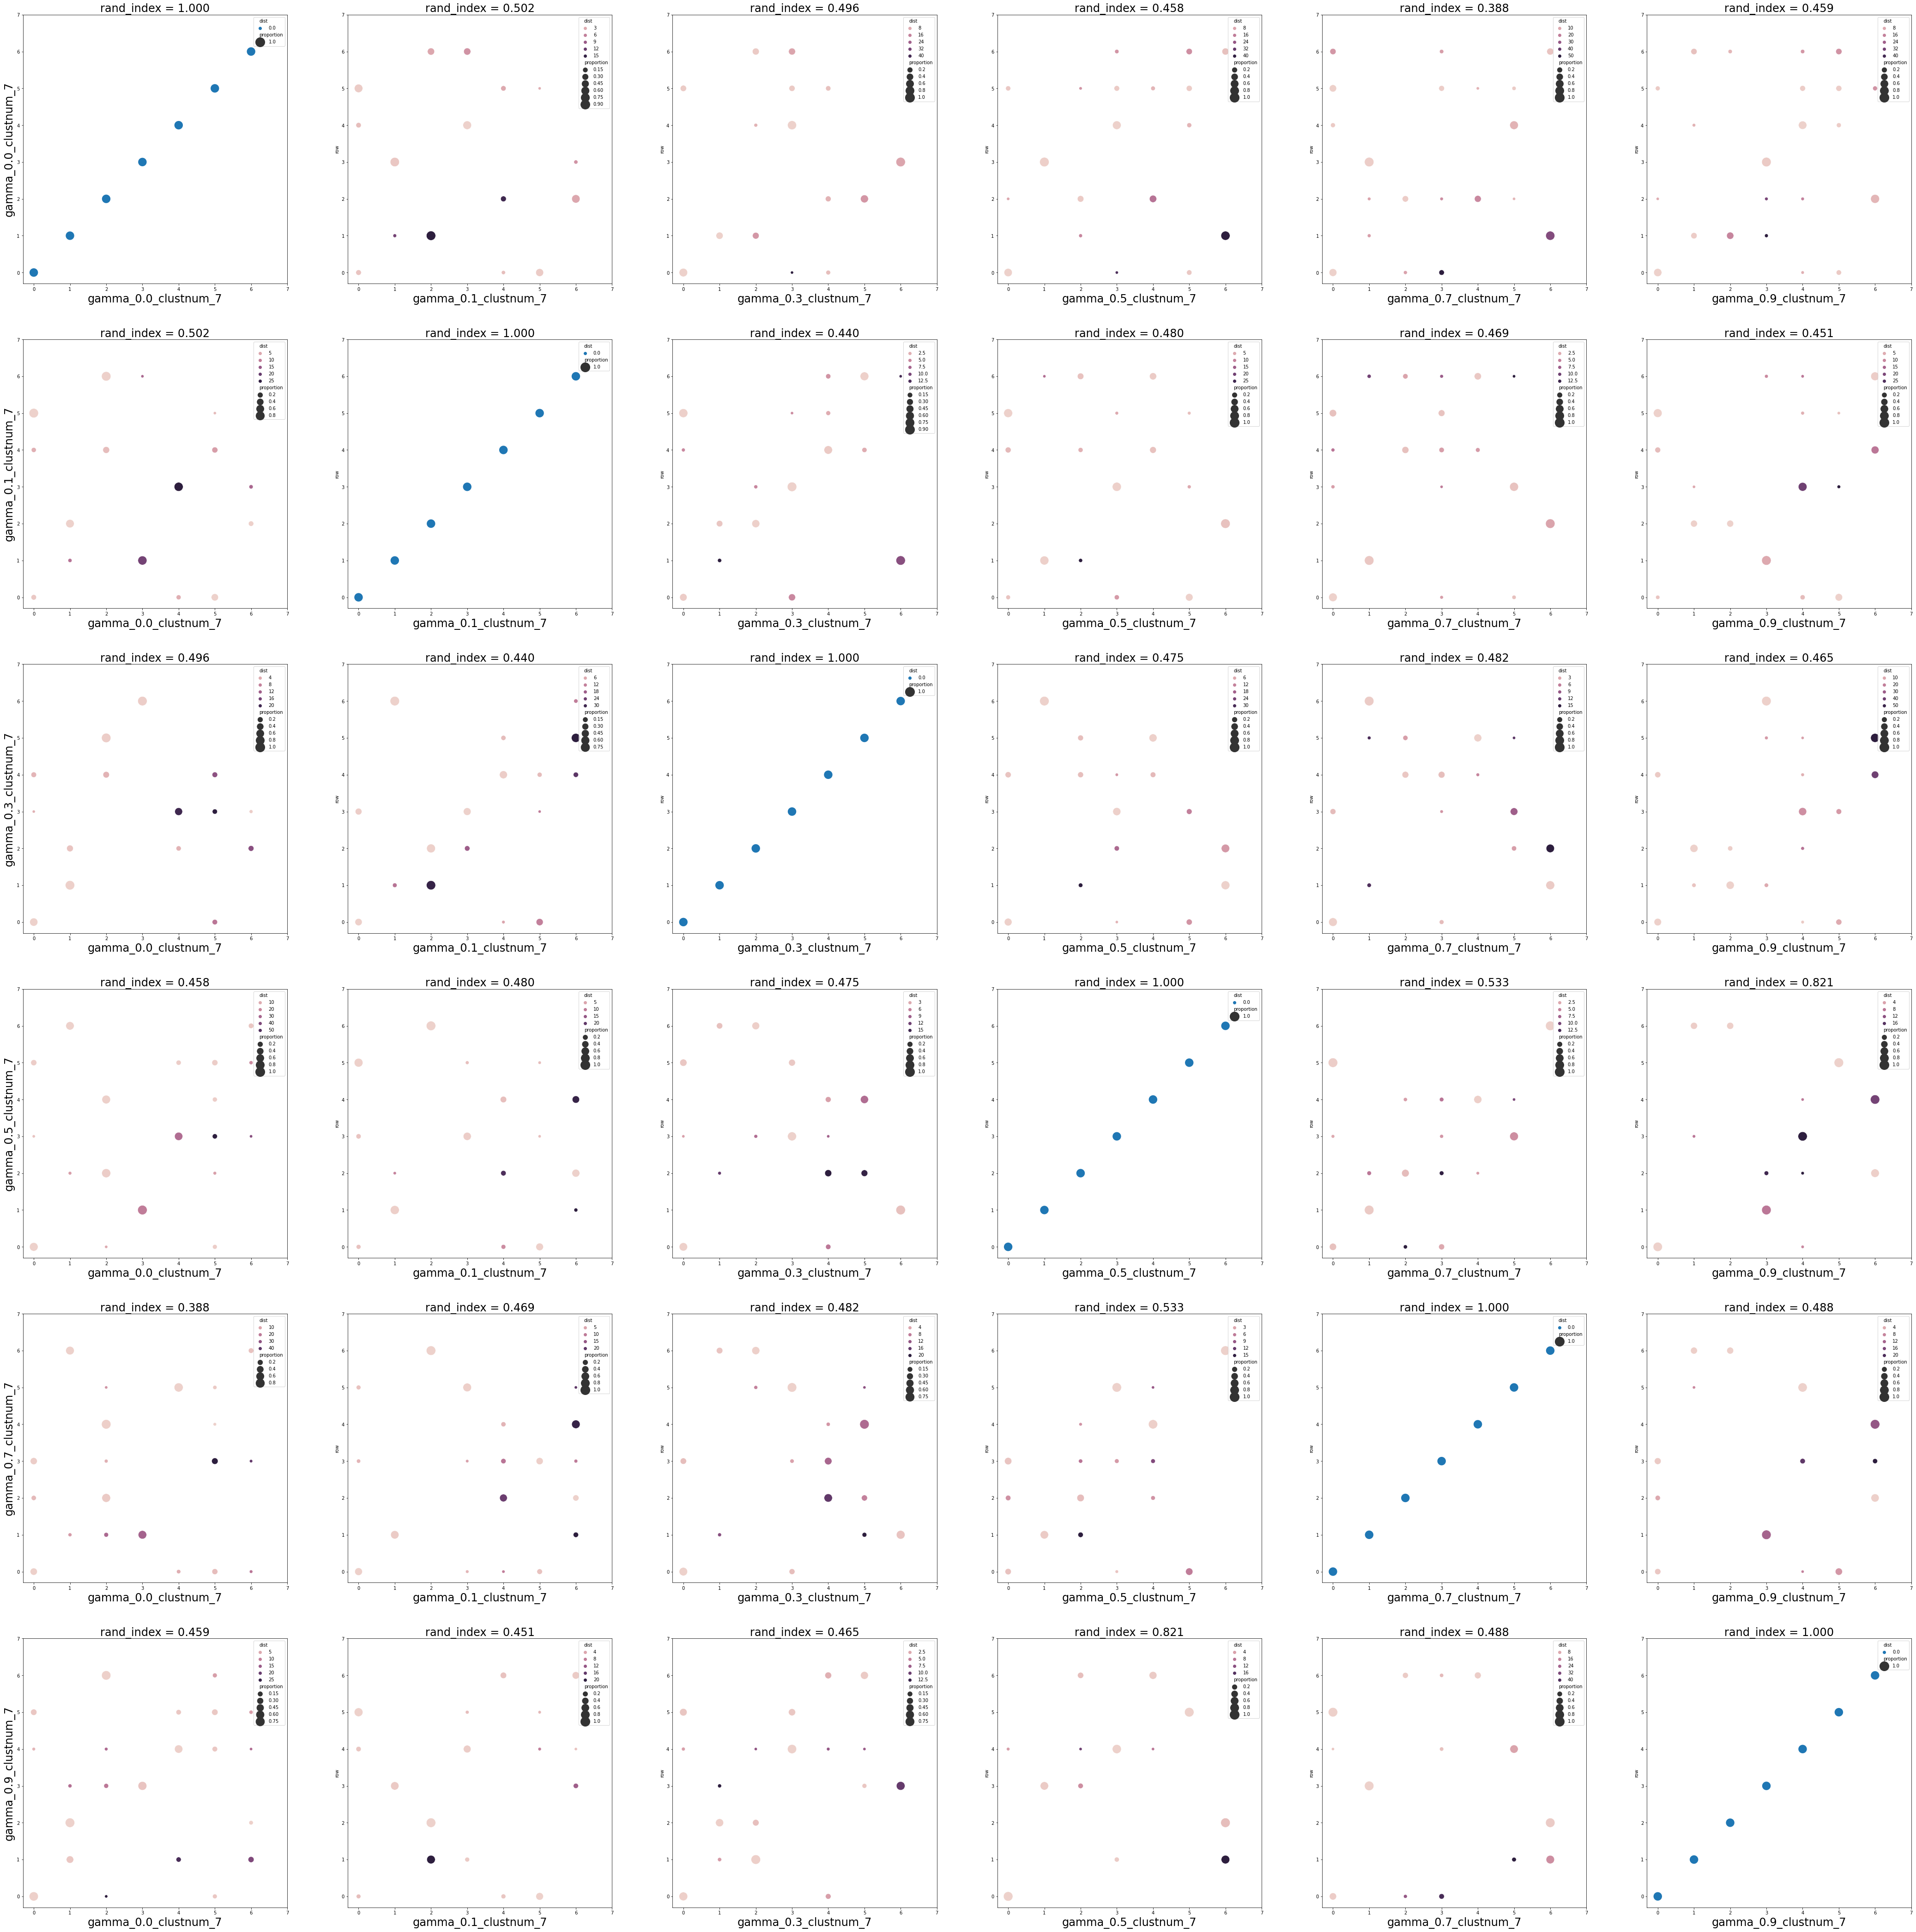

In [14]:
plot_gamma_clustnum_diff_matrix(gamma_clustnum_df_holder, gammas, 7)

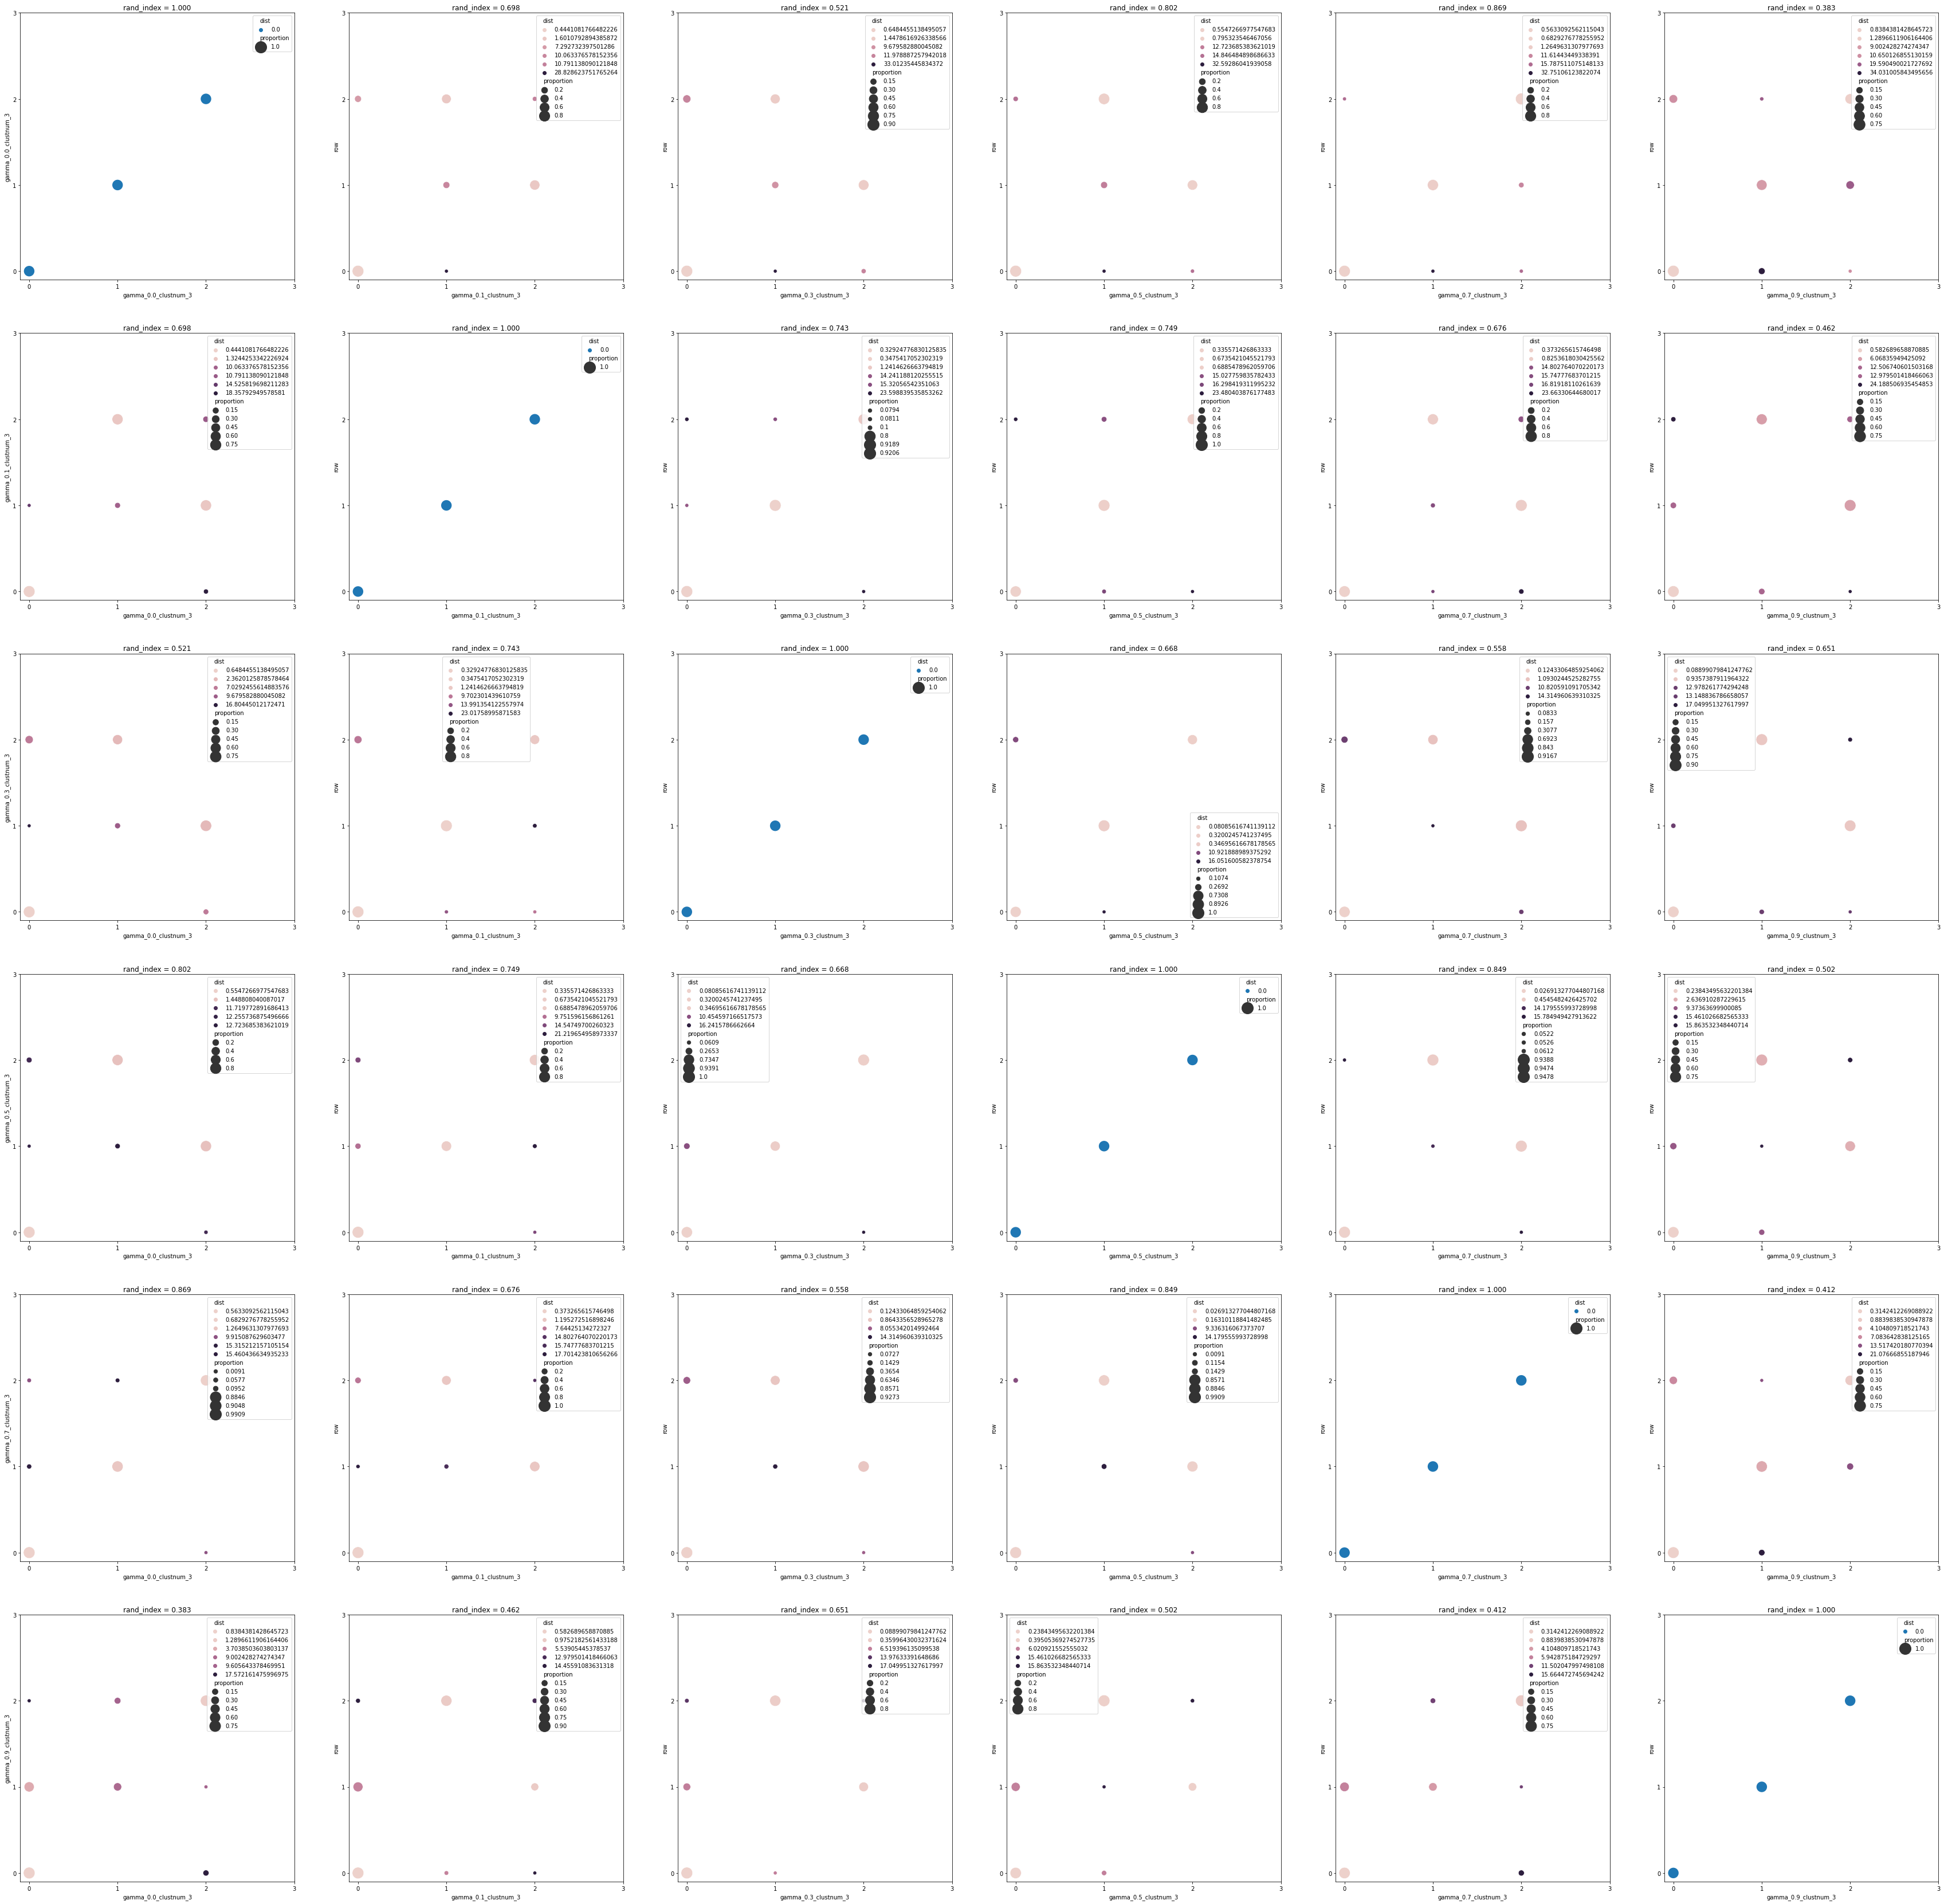

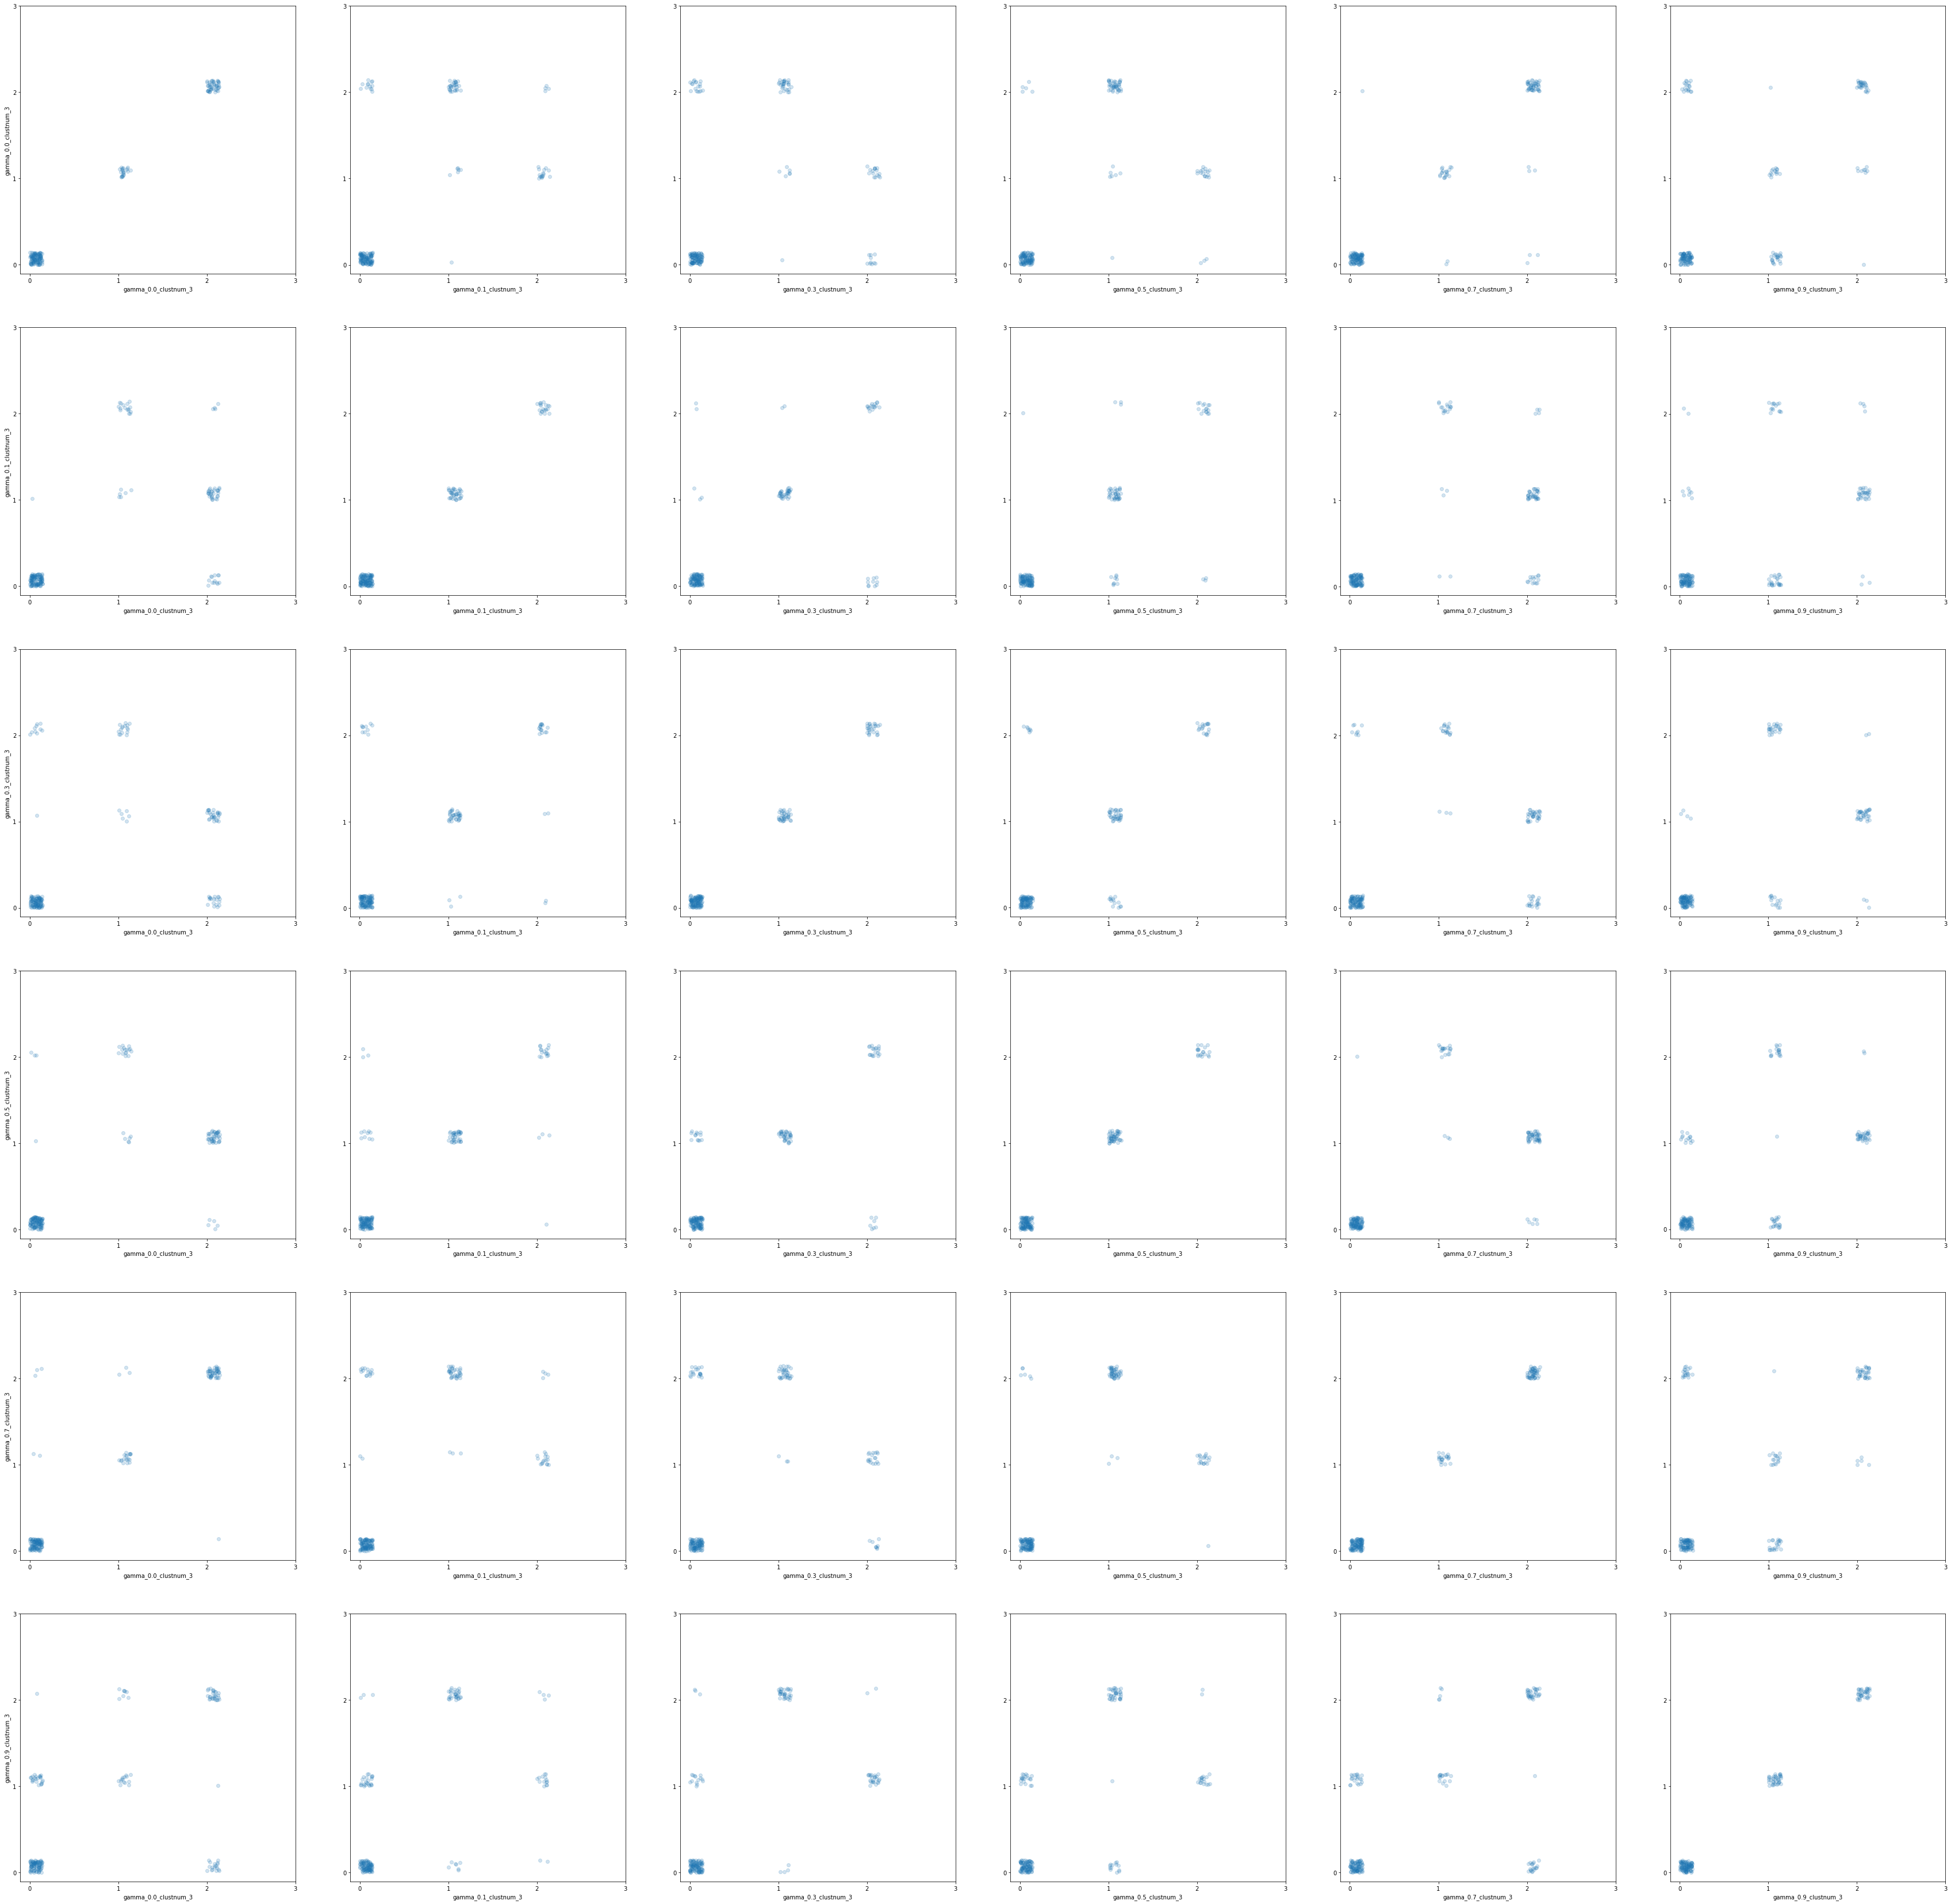

In [ ]:
'''
Good example of cluster confusion occurs when clusters 2 and 6 from 
gamma_0.1_clustnum_7 are essentially combined in gamma_0.3_clustnum_7

increasing gamma seems to cause more condensation than separation
of certain clusters of a lower gamma

Make square plot
'''
plot_gamma_clustnum_diff_matrix(gamma_clustnum_df_holder, gammas, 3)
# plot_gamma_clustnum_diff_matrix_old(gamma_clustnum_df_holder, gammas, 3)

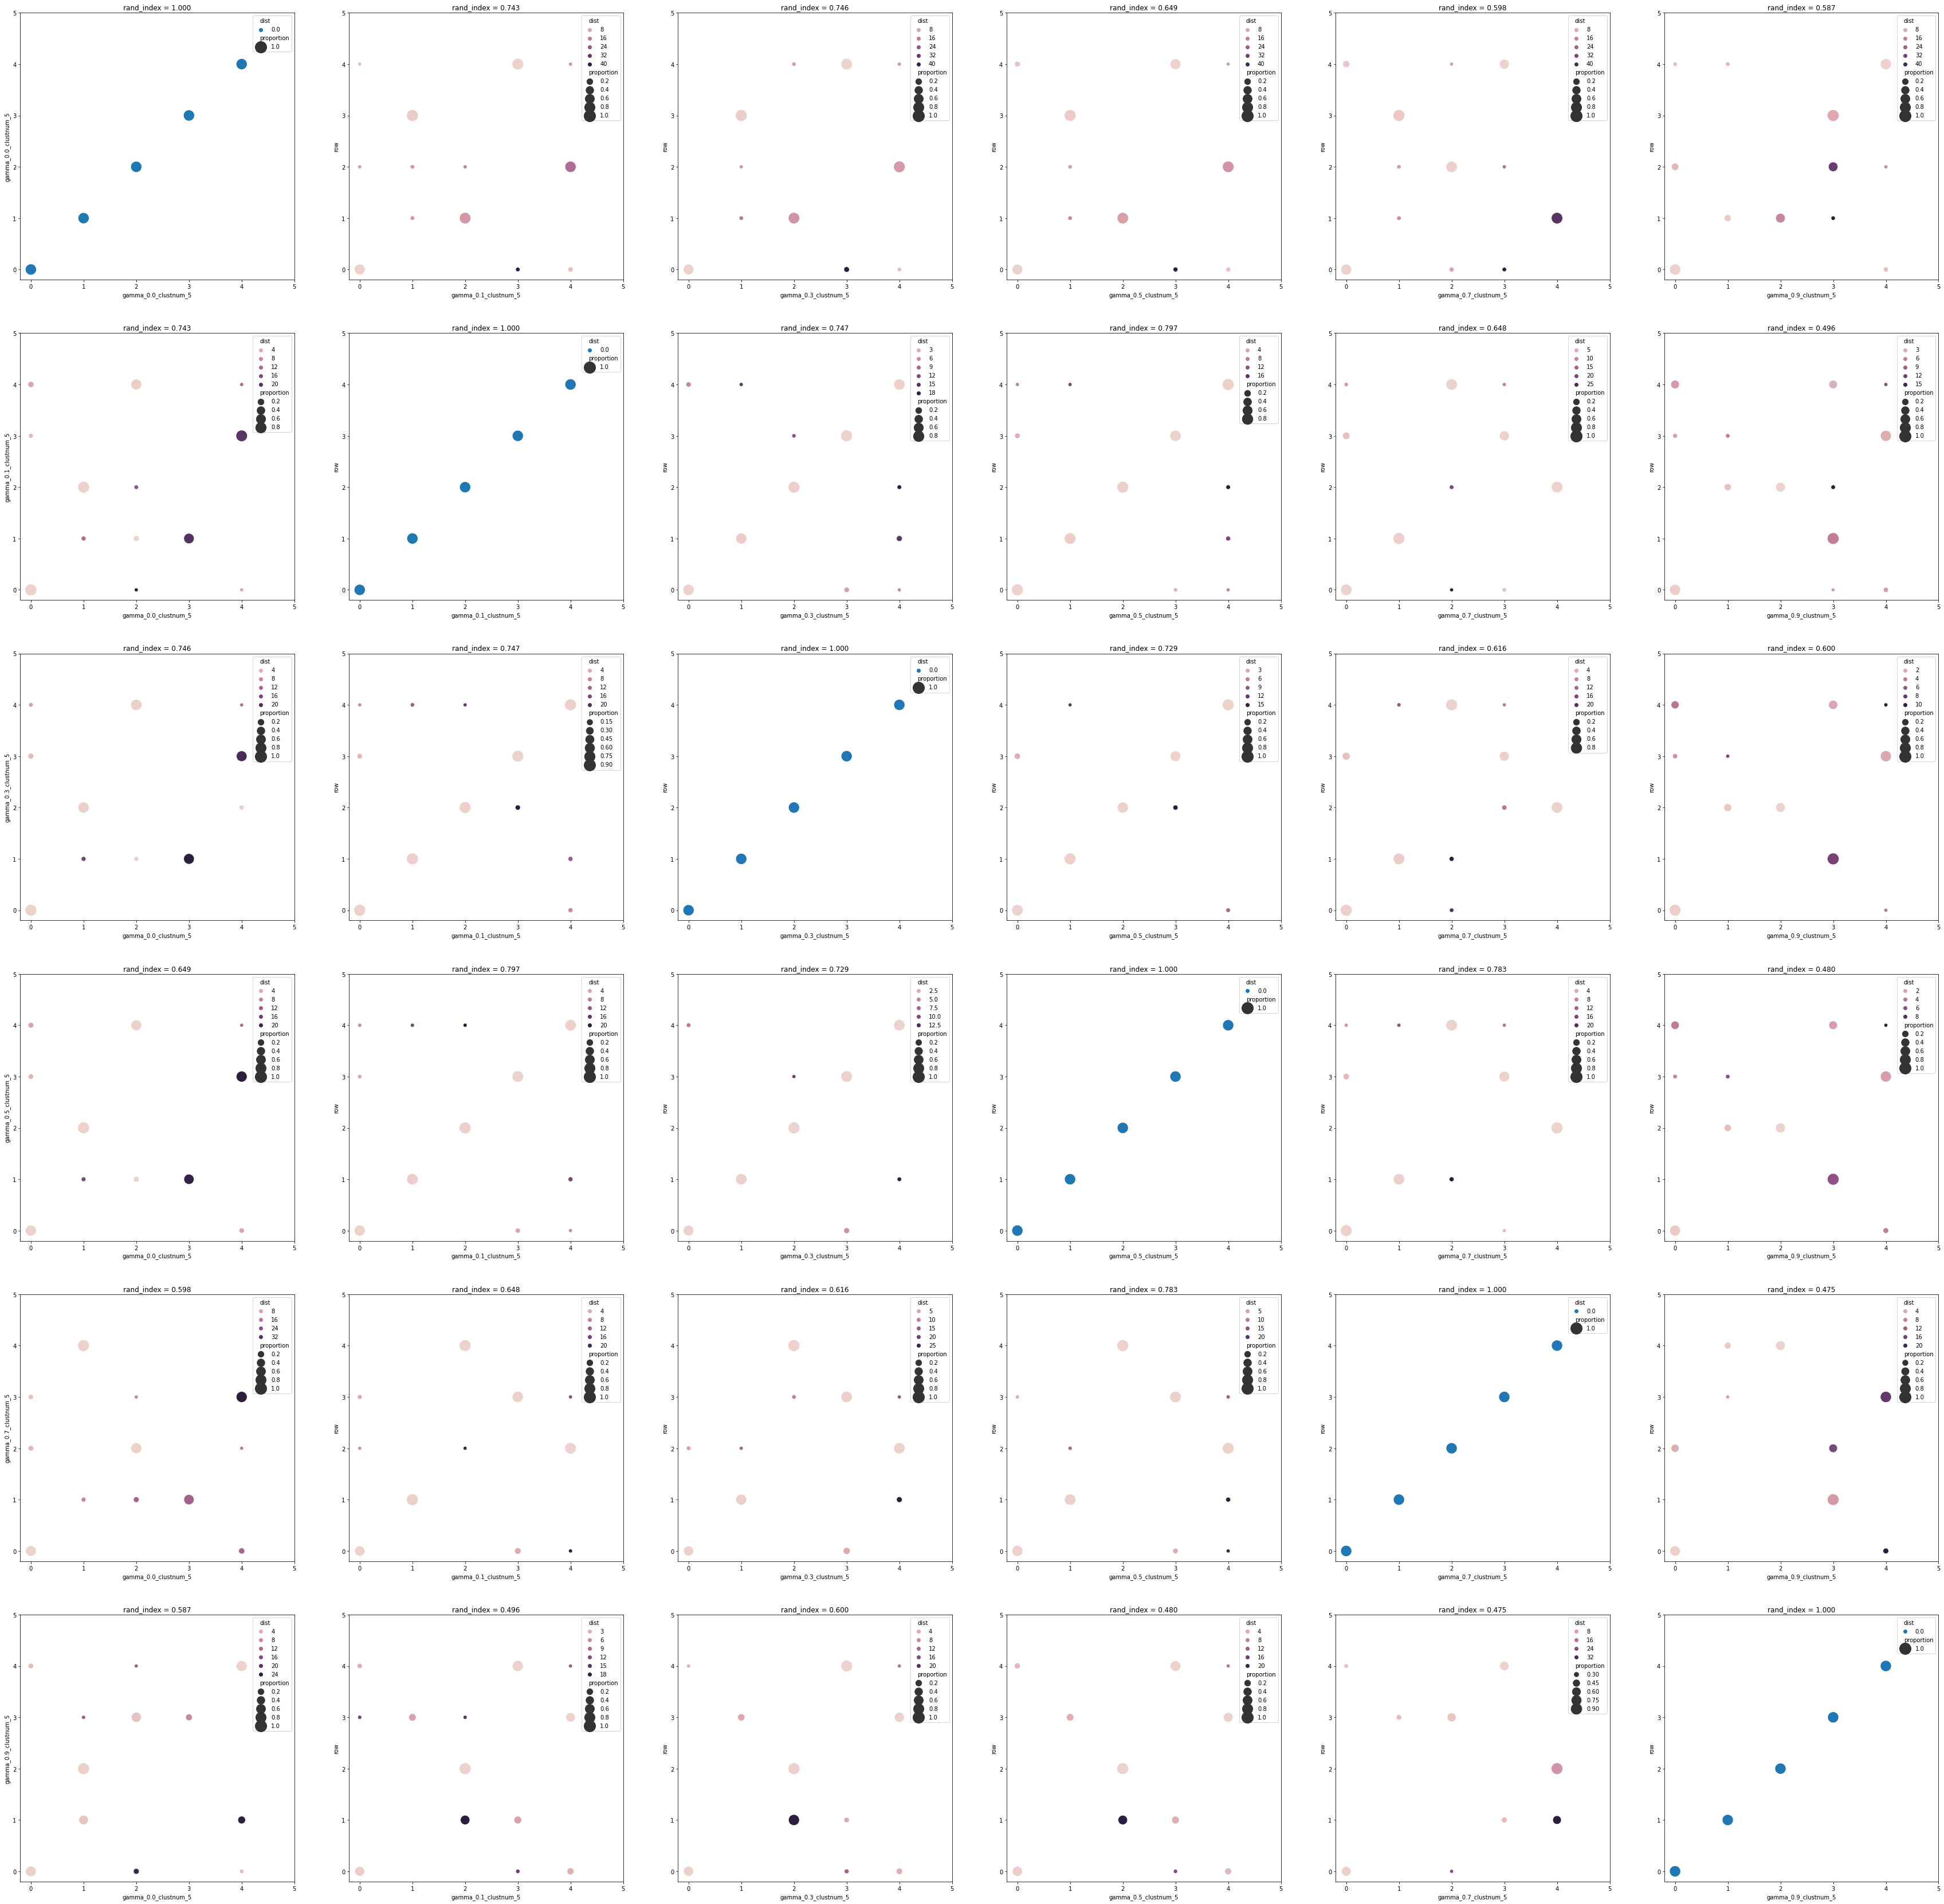

In [ ]:
'''
What we want: Pick a gamma that is consistent, i.e. doesn't
throw off cluster membership significantly when changing gamma

K=5 is actually fairly stable for most of the gamma changes.
Kinda goes crazy at gamma=0.

Might be an example to aim for
'''

plot_gamma_clustnum_diff_matrix(gamma_clustnum_df_holder, gammas, 5)
# plot_gamma_clustnum_diff_matrix_old(gamma_clustnum_df_holder, gammas, 5)

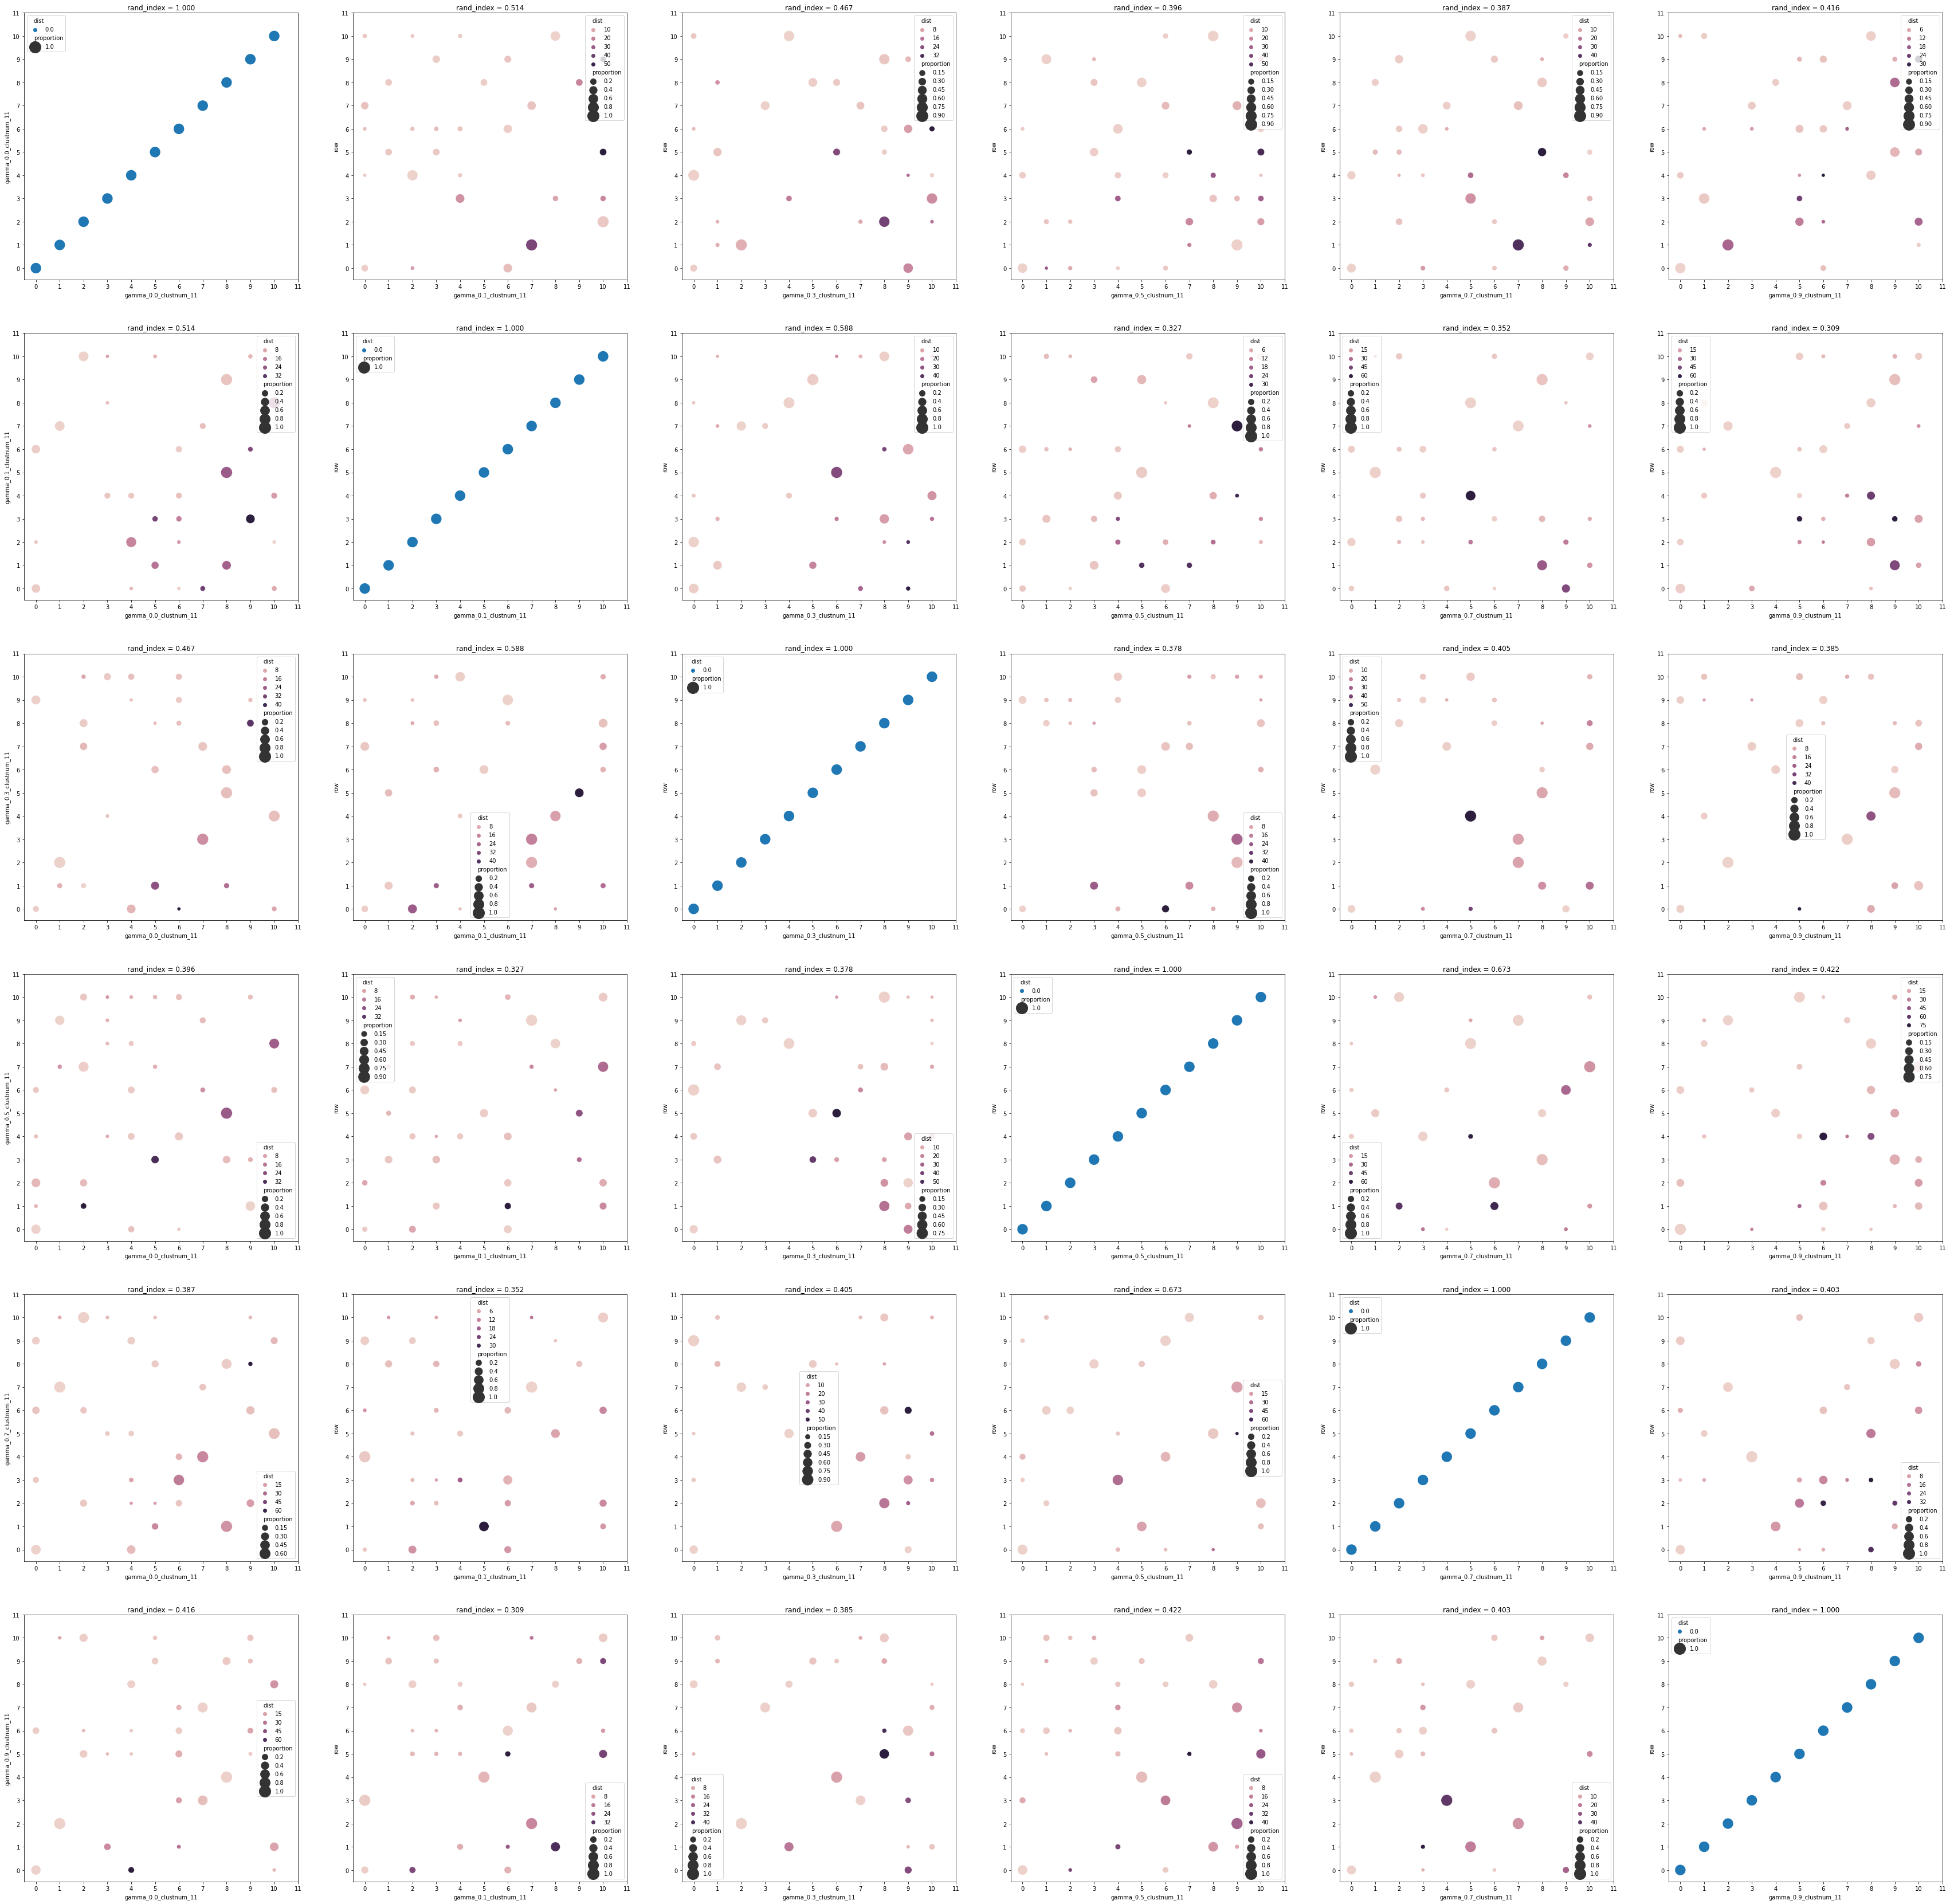

In [ ]:
plot_gamma_clustnum_diff_matrix(gamma_clustnum_df_holder, gammas, 11)
# plot_gamma_clustnum_diff_matrix_old(gamma_clustnum_df_holder, gammas, 11)

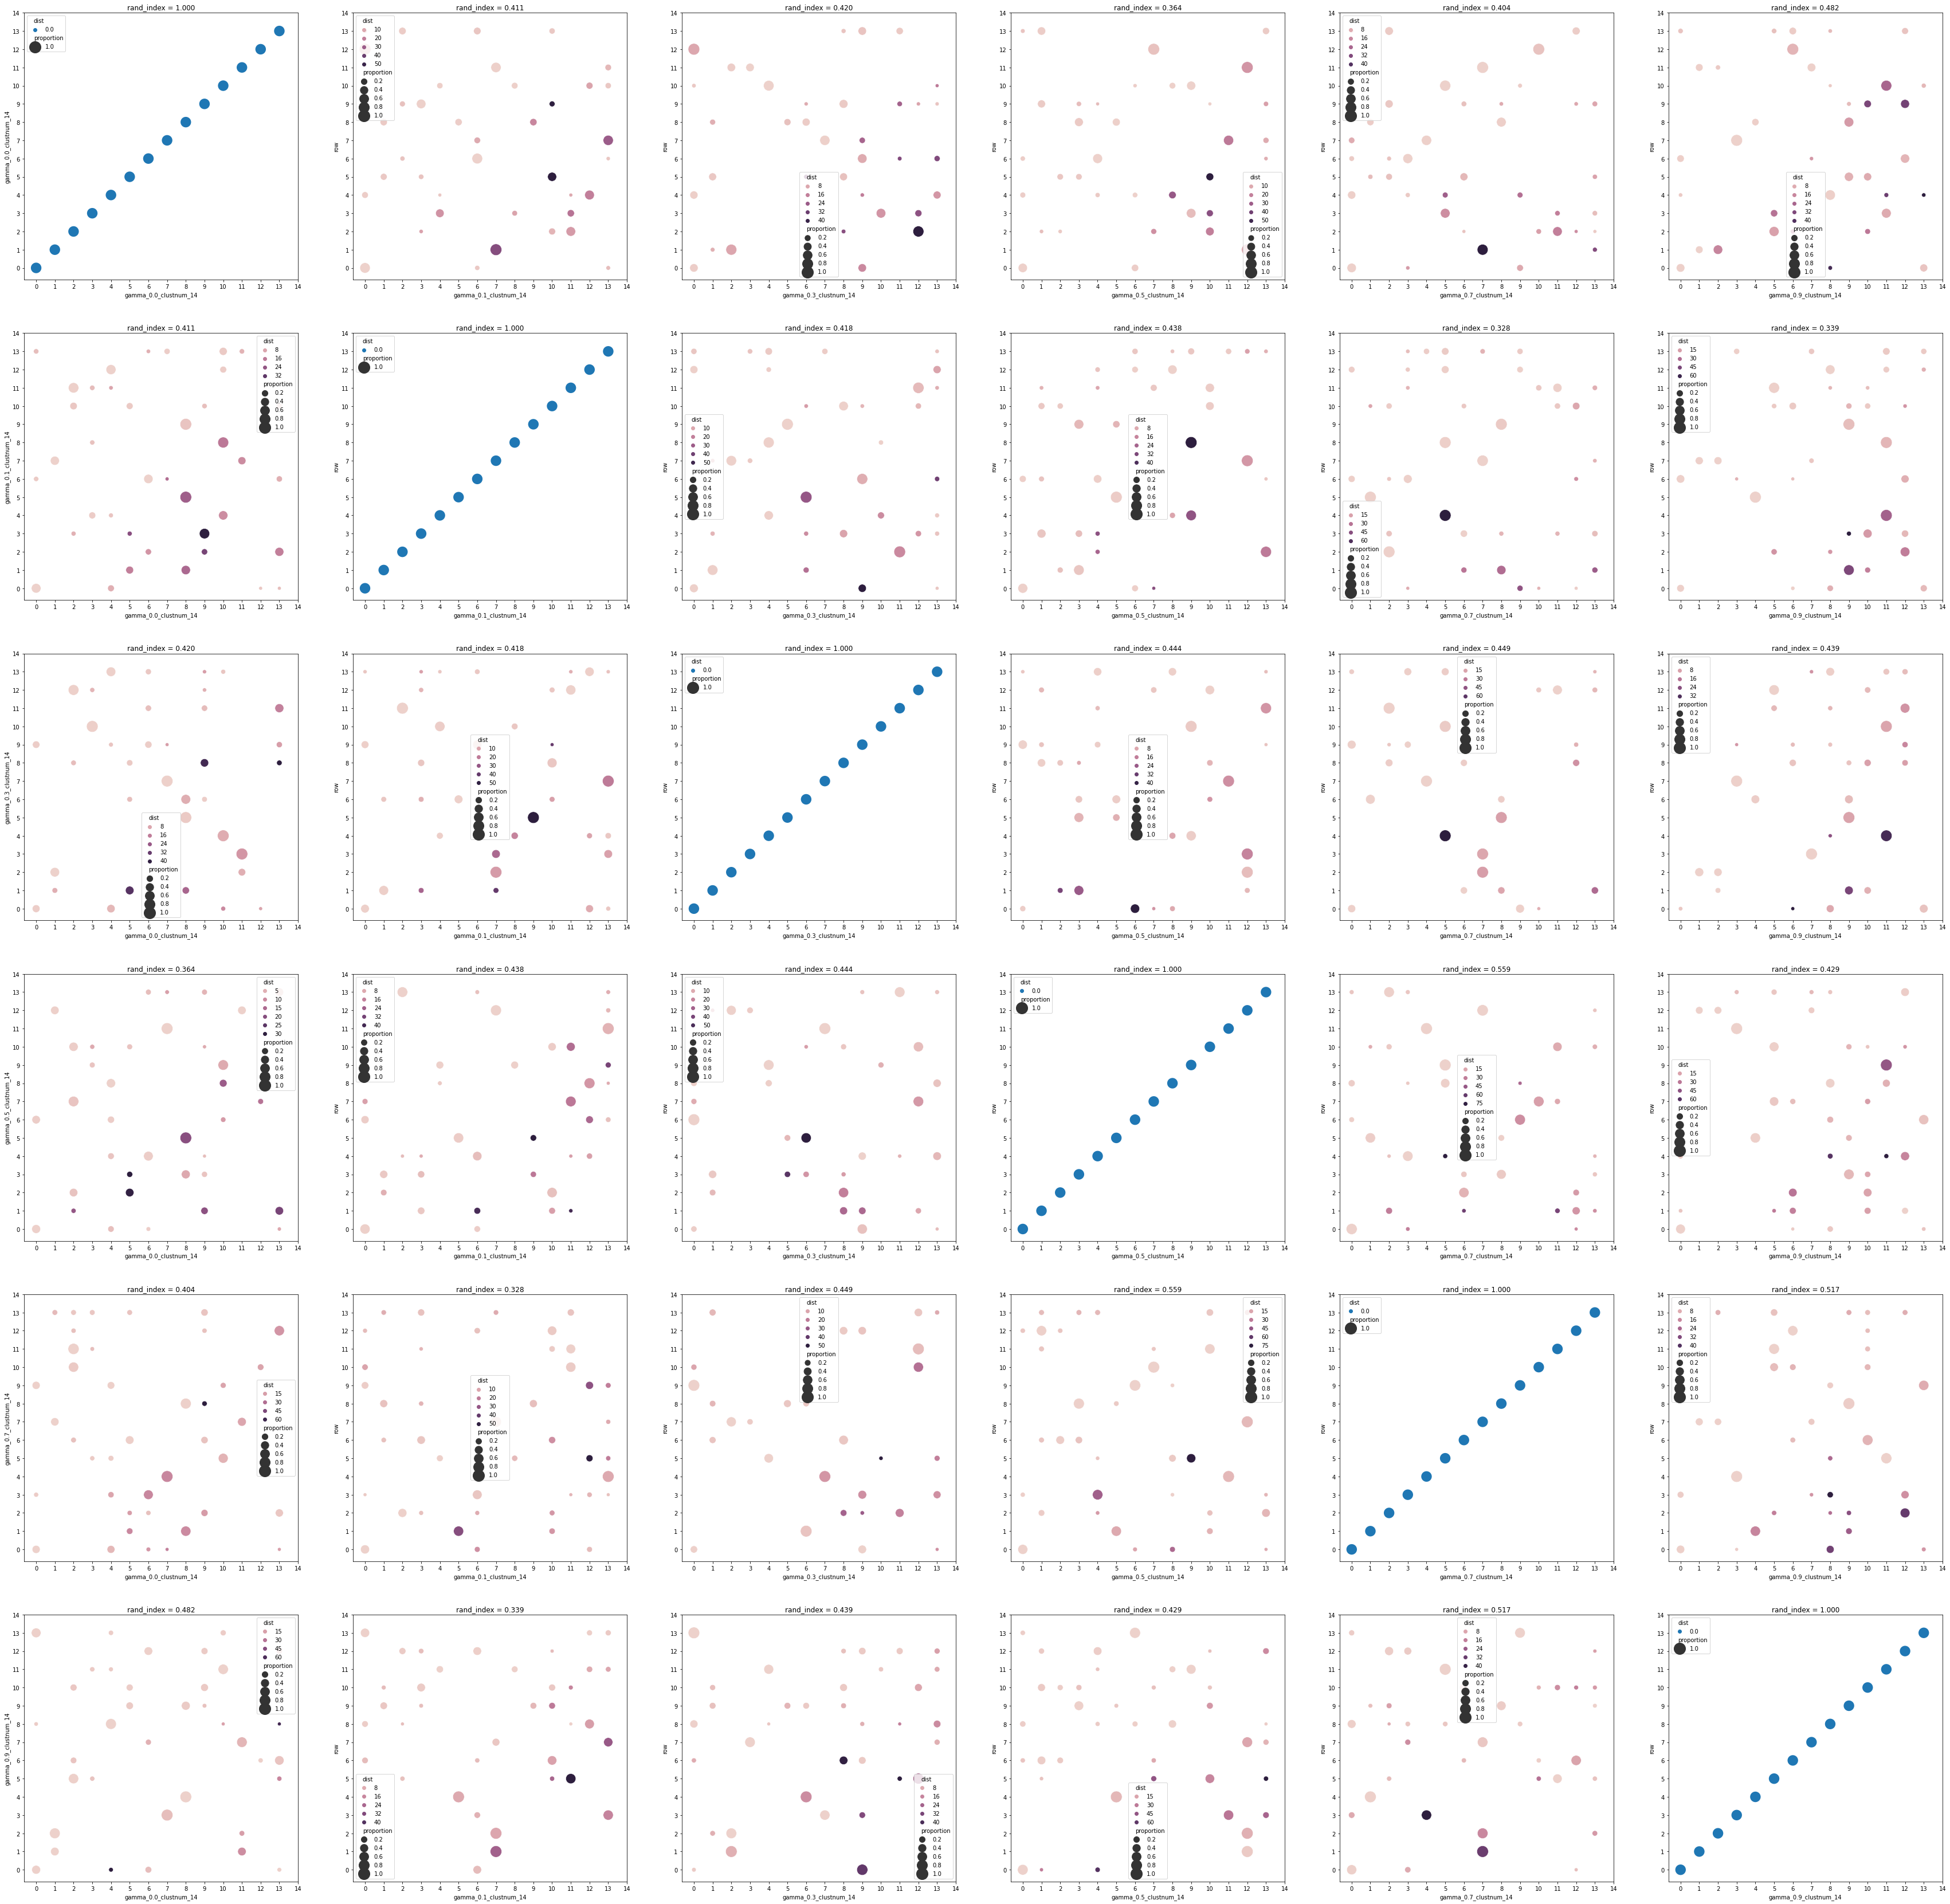

In [ ]:
plot_gamma_clustnum_diff_matrix(gamma_clustnum_df_holder, gammas, 14)

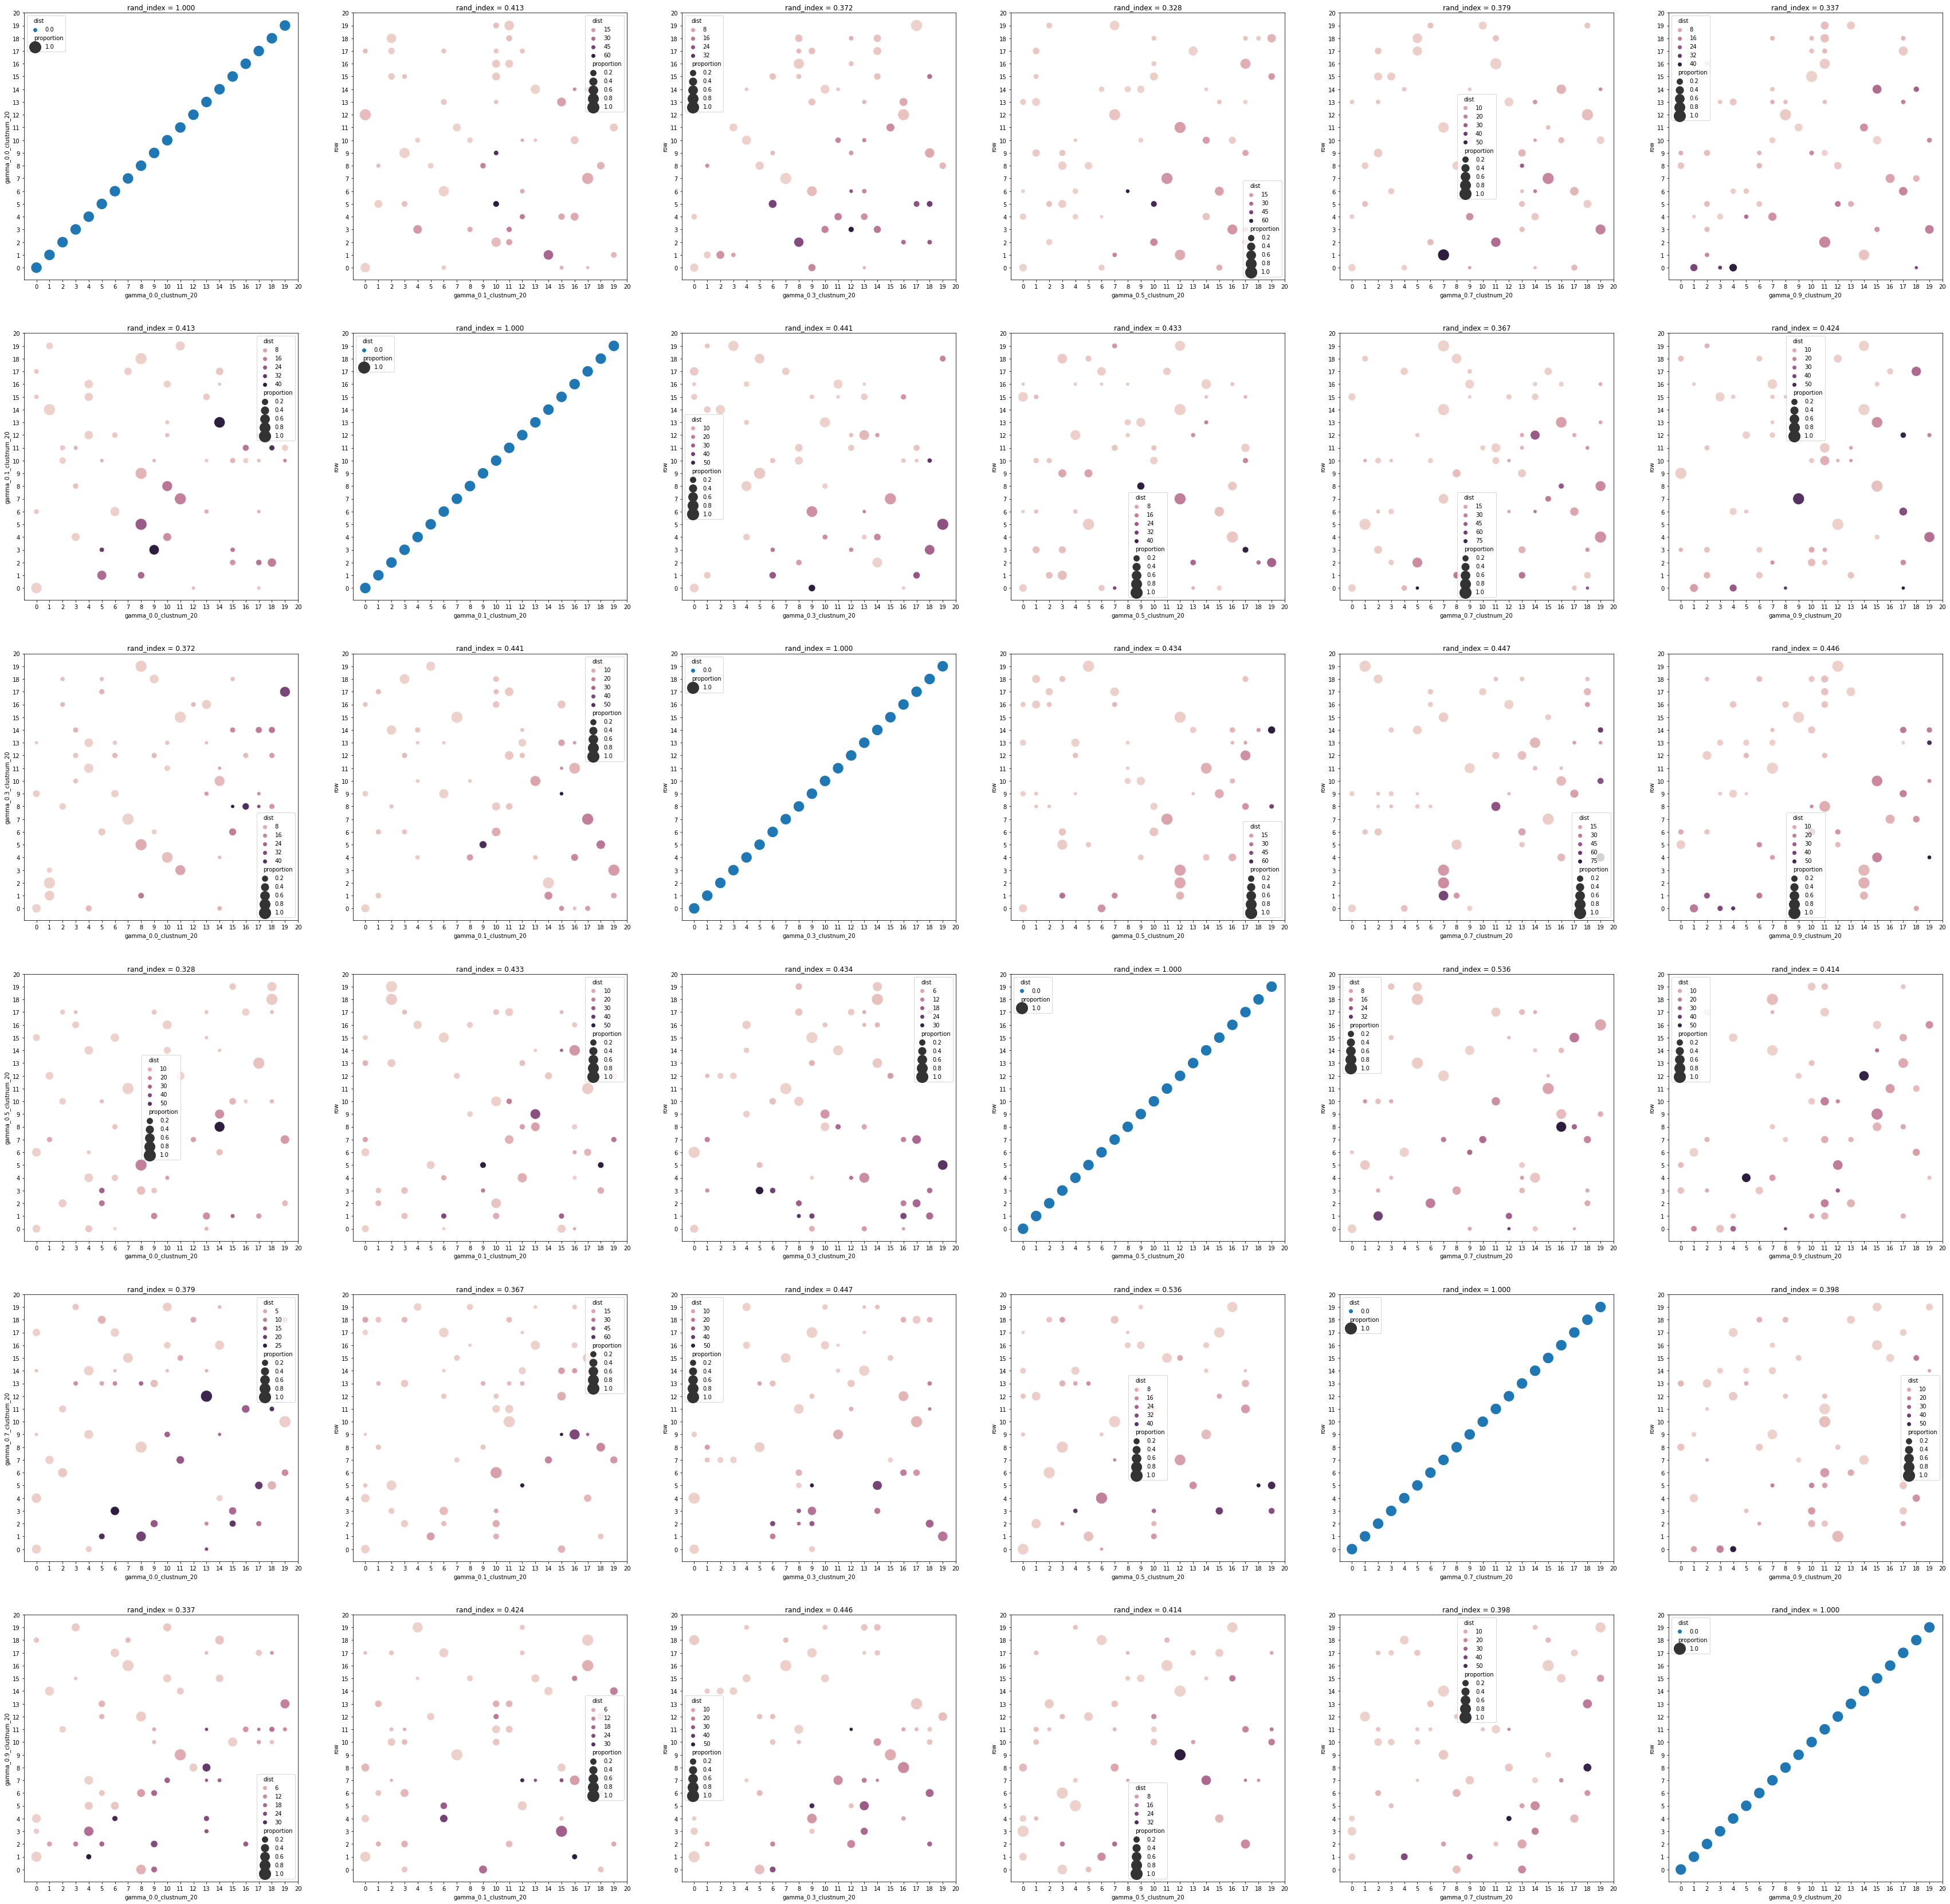

In [ ]:
plot_gamma_clustnum_diff_matrix(gamma_clustnum_df_holder, gammas, 20)

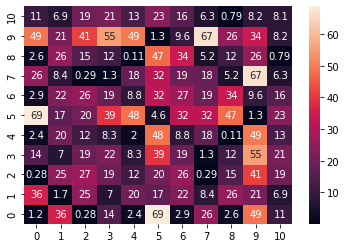

In [ ]:
# Initialize distance matrix
# Normalize the curves
from tslearn.metrics import soft_dtw 
import seaborn as sns
# Read in clustering model
os.listdir(clusteringListPath + "gamma_0.1/clusternum_11")
hd5path = clusteringListPath + "gamma_0.1/clusternum_11/gamma_0.1_clusternum_11.hdf5"
hd5path2 = clusteringListPath + "gamma_0.3/clusternum_11/gamma_0.3_clusternum_11.hdf5"
km = TimeSeriesKMeans.from_hdf5(hd5path)
km2 = TimeSeriesKMeans.from_hdf5(hd5path2)
# Read clustering centers ndarray
data = km.cluster_centers_ # Each ts is (63, 2) in shape i.e. array( [time, lambda], [time, lambda], ...] )
data2 = km2.cluster_centers_ # Each ts is (63, 2) in shape i.e. array( [time, lambda], [time, lambda], ...] )

cluster_center_data_path = clusteringListPath + "gamma_0.1/clusternum_11/gamma_0.1_clusternum_11_cluster_barycenters.npy"


distance_matrix = np.zeros((len(data), len(data))) # clustnum x clustnum
for idx, i in enumerate(data):
    for jdx, j in enumerate(data2):
        # Calculate pairwise distances using dynamic time warping
        distance  = soft_dtw(i, 
                             j, 
                             gamma=0)
        distance_matrix[idx][jdx] = distance
        distance_matrix[jdx][idx] = distance
sns.heatmap(distance_matrix,annot=True).invert_yaxis()

